In [42]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Galaxy Shape Demo

In [43]:
simname = 'Illustris-1'
snapNum = 99

from Illustris_Shapes.simulation_props import sim_prop_dict
d = sim_prop_dict[simname]
basePath = d['basePath']
Lbox = d['Lbox']

from astropy.table import Table
fname = simname + '_' + str(snapNum) + '_' + 'reduced' + '_' +'galaxy_shapes'+ '.dat' 
t_1 = Table.read('../data/shape_catalogs/'+fname, format='ascii')

## Example Galaxy

In [238]:
i = 3
gal_id = t_1['gal_id'][i]

## load galaxy particles

In [239]:
# choose a 'center' for each galaxy
gal_position = galaxy_center(gal_id, basePath, snapNum)

# load stellar particle positions and masses
ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Coordinates'])/1000.0
ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Masses'])*10.0**10

# center and account for PBCs
ptcl_coords = format_particles(gal_position, ptcl_coords, Lbox)

ptcl_mask = particle_selection(gal_id, ptcl_coords, basePath, snapNum, radial_mask=True)

ptcl_coords = ptcl_coords[ptcl_mask]
ptcl_masses = ptcl_masses[ptcl_mask]

# get the half mass radius
gal_rhalfs = loadSubhalos(basePath, snapNum, fields=['SubhaloHalfmassRadType'])[:,4]/1000.09
gal_rhalf = gal_rhalfs[gal_id]

## recalculate I

In [240]:
from inertia_tensors import reduced_inertia_tensors, inertia_tensors
I = reduced_inertia_tensors(ptcl_coords, weights=ptcl_masses)
evals, evecs = np.linalg.eigh(I)

print(np.sqrt(evals[0, ::-1]))
print(t_1['a'][i], t_1['b'][i], t_1['c'][i])

print('')
print(evecs[0,:,2])
print(Av_1[i])
print('')
print(evecs[0,:,1])
print(Bv_1[i])
print('')
print(evecs[0,:,0])
print(Cv_1[i])

a = t_1['a'][i]
b = t_1['b'][i]
c = t_1['c'][i]

[0.65122907 0.63981176 0.40808899]
0.6512290650751824 0.6398117552802419 0.4080889906698137

[0.78729935 0.45801625 0.41277216]
[-0.90184676  0.12763842  0.41277216]

[-0.54788971  0.82675589  0.12763842]
[0.32664326 0.82675589 0.45801625]

[ 0.28280134  0.32664326 -0.90184676]
[ 0.28280134 -0.54788971  0.78729935]


## rotate into eigenvector axis

In [246]:
from rotations.rotations3d import rotation_matrices_from_basis
from rotations import rotate_vector_collection

Av_1 = np.vstack((t_1['av_x'], t_1['av_y'], t_1['av_z'])).T
Bv_1 = np.vstack((t_1['bv_x'], t_1['bv_y'], t_1['bv_z'])).T
Cv_1 = np.vstack((t_1['cv_x'], t_1['cv_y'], t_1['cv_z'])).T

rot = rotation_matrices_from_basis([evecs[0,:,2]], [evecs[0,:,1]], [evecs[0,:,0]])
#rot = np.linalg.inv(rot)[0]
rot = rot[0].T

a = t_1['a'][i]
b = t_1['b'][i]
c = t_1['c'][i]

print(rot)

[[ 0.78729935  0.45801625  0.41277216]
 [-0.54788971  0.82675589  0.12763842]
 [ 0.28280134  0.32664326 -0.90184676]]


In [247]:
xx = rotate_vector_collection(rot, ptcl_coords)/gal_rhalf 
from inertia_tensors import reduced_inertia_tensors

I = reduced_inertia_tensors(xx, weights=ptcl_masses)
evals, evecs = np.linalg.eigh(I)
print(evecs[0,:,2])
print(evecs[0,:,1])
print(evecs[0,:,0])

print('')
print(np.sqrt(evals[0,2]))
print(np.sqrt(evals[0,1]))
print(np.sqrt(evals[0,0]))
print(a, b, c)


[-1.00000000e+00 -1.05673113e-13 -1.21822936e-15]
[-1.05673113e-13  1.00000000e+00  4.41985516e-15]
[-1.21822936e-15 -4.43556604e-15  1.00000000e+00]

0.6512290650751861
0.6398117552802419
0.4080889906698167
0.6512290650751824 0.6398117552802419 0.4080889906698137


In [248]:
I = reduced_inertia_tensors(ptcl_coords, weights=ptcl_masses)
evals, evecs = np.linalg.eigh(I)

print('')
print(evals[0,2])
print(evals[0,1])
print(evals[0,0])
print(a, b, c)

rot = np.zeros((3,3))
rot[:,0] = evecs[0,:,2]
rot[:,1] = evecs[0,:,1]
rot[:,2] = evecs[0,:,0]
rot = rot.T

print(rot)


0.4240992951986961
0.4093590821947841
0.16653662430590727
0.6512290650751824 0.6398117552802419 0.4080889906698137
[[ 0.78729935  0.45801625  0.41277216]
 [-0.54788971  0.82675589  0.12763842]
 [ 0.28280134  0.32664326 -0.90184676]]


## make image

In [249]:
bins = np.linspace(-3,3,100)
counts_xy = np.log10(np.histogram2d(xx[:,0], xx[:,1], bins=bins, weights=ptcl_masses)[0])
counts_xz = np.log10(np.histogram2d(xx[:,0], xx[:,2], bins=bins, weights=ptcl_masses)[0])
counts_yz = np.log10(np.histogram2d(xx[:,1], xx[:,2], bins=bins, weights=ptcl_masses)[0])

#counts_xy = np.histogram2d(xx[:,0], xx[:,1], bins=bins, weights=ptcl_masses)[0]
#counts_xz = np.histogram2d(xx[:,0], xx[:,2], bins=bins, weights=ptcl_masses)[0]
#counts_yz = np.histogram2d(xx[:,1], xx[:,2], bins=bins, weights=ptcl_masses)[0]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


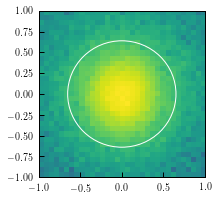

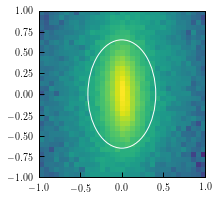

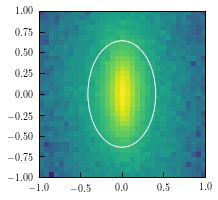

In [250]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1,1, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.imshow(counts_xy, extent=[-3,3,-3,3], origin='lower')
ellipse_0 = Ellipse([0,0], 2*a, 2*b, angle=0, facecolor='none', edgecolor='white')
ax.add_artist(ellipse_0)
#plt.plot([0,a],[0,0], '-', color='black')
#plt.plot([0,0],[0,b], '-', color='black')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.imshow(counts_xz, extent=[-3,3,-3,3], origin='lower')
#plt.plot(xx[:,0], xx[:,2], '.', ms=1, alpha=0.01)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=90, facecolor='none', edgecolor='white')
ax.add_artist(ellipse_0)
#plt.plot([0,0],[0,c], '-', color='black')
#plt.plot([0,a],[0,0], '-', color='black')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.imshow(counts_yz, extent=[-3,3,-3,3], origin='lower')
#plt.plot(xx[:,1], xx[:,2], '.', ms=1, alpha=0.01)
ellipse_0 = Ellipse([0,0], 2*b, 2*c, angle=90, facecolor='none', edgecolor='white')
ax.add_artist(ellipse_0)
#plt.plot([0,0],[0,c], '-', color='black')
#plt.plot([0,b],[0,0], '-', color='black')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

# utility functions

In [37]:
from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos

def format_particles(center, coords, Lbox):
    """
    center the partivcle coordinates on (0,0,0) and account for PBCs

    Parameters
    ----------
    center : array_like
        array of shape (3,) storing the coordinates of the
        center of the particle distribution

    coords :  array_like
        array of shape (nptcls, 3) storing the coordinates of the
        particles

    Lbox : array_like
        length 3-array giving the box size in each dimension

    Returns
    -------
    coords : numpy.array
        array of shape (nptcls, 3) storing the centered particle coordinates
    """

    dx = coords[:,0] - center[0]
    dy = coords[:,1] - center[1]
    dz = coords[:,2] - center[2]

    # x-coordinate
    mask = (dx > Lbox[0]/2.0)
    dx[mask] = dx[mask] - Lbox[0]
    mask = (dx < -Lbox[0]/2.0)
    dx[mask] = dx[mask] + Lbox[0]

    # y-coordinate
    mask = (dy > Lbox[1]/2.0)
    dy[mask] = dy[mask] - Lbox[1]
    mask = (dy < -Lbox[1]/2.0)
    dy[mask] = dy[mask] + Lbox[1]

    # z-coordinate
    mask = (dz > Lbox[2]/2.0)
    dz[mask] = dz[mask] - Lbox[2]
    mask = (dz < -Lbox[2]/2.0)
    dz[mask] = dz[mask] + Lbox[2]

    # format coordinates
    coords = np.vstack((dx,dy,dz)).T

    return coords


def particle_selection(gal_id, ptcl_coords, basePath, snapNum, radial_mask=True):
    """
    Apply the selection criteria to galaxy particles

    Returns
    -------
    mask : numpy.array
       boolean array of shape (nptcls,)
    """

    # don't use wind particles
    sf_time = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['GFM_StellarFormationTime'])
    star_mask = (sf_time>=0.0) # don't use wind particles

    # get the half mass radius
    gal_rhalfs = loadSubhalos(basePath, snapNum, fields=['SubhaloHalfmassRadType'])[:,4]/1000.0
    gal_rhalf = gal_rhalfs[gal_id]

    # use only particles within 2 * R_half
    r = np.sqrt(np.sum(ptcl_coords**2, axis=1))/gal_rhalf
    if radial_mask:
        radial_mask = (r<=2.0)
    else:
        radial_mask = np.array([True]*len(star_mask))

    return (radial_mask) & (star_mask)


def galaxy_center(gal_id, basePath, snapNum):
    """
    Return the coordinates of the center of the galaxy
    """

    # load position of the most bound particle (of any type)
    coords = loadSubhalos(basePath, snapNum, fields=['SubhaloPos'])/1000.0
    coord = coords[gal_id]

    return coord